# Functions

In [ ]:
# #Uncomment the two lines below to install packages
# !pip install --trusted-host pypi.org --trusted-host files.pythonhosted.org aspose-words
# !pip install --trusted-host pypi.org --trusted-host files.pythonhosted.org pyperclip

import urllib.request, json
import aspose.words as aw
from datetime import datetime as dt

import pyperclip
import numpy as np
import time

#Place personal key here in string format
KEY = 'INSERT_KEY_HERE'

##Queries ChatGPT with the prompt (includes request and main body)
##Optional parameters of Temprature, Top_percent, and GPT Class 3/4
def gptRespond(prompt, t = 1, c = 1, GPT = 3):
    try:
        url = "https://apigw.rand.org/openai/RAND/inference/deployments/gpt-35-turbo-v0301-base/chat/completions?api-version=2023-03-15-preview"

        if (GPT == 3):
            model = 'gpt-35-turbo'
            key = KEY
        elif (GPT == 4):
            model = 'gpt-4-v0314-base'
            key = KEY
        else:
            print("Model not available.")
            return 
            
        hdr ={
        # Request headers
        'Content-Type': 'application/json',
        'Cache-Control': 'no-cache',
        'Ocp-Apim-Subscription-Key': key,
        }

        # Request body
        data = {'model': model, 'messages': [{'role': 'user', 'content': prompt}], 'temperature': t, 'top_p' : c}
        data = json.dumps(data)
        req = urllib.request.Request(url, headers=hdr, data = bytes(data.encode("utf-8")))

        req.get_method = lambda: 'POST'
        response = urllib.request.urlopen(req)

        content = bytes.decode(response.read(), 'utf-8') #return string value
        res = json.loads(content)
        return res['choices'][0]['message']['content']
    except Exception as e:
        print(e)

        
##Insert two text files, counts number of "edits"
##Optional save variable, allows saving merged document
def numEdits(original, edited, save = False, name = "output"):
    # The source document doc1.
    doc1 = aw.Document()
    builder = aw.DocumentBuilder(doc1)
    builder.writeln(original)

    # The target document doc2.
    doc2 = aw.Document()
    builder = aw.DocumentBuilder(doc2)
    builder.writeln(edited)

    # Doc1 now contains changes as revisions.
    doc1.compare(doc2, "GPT", dt.today())
    
    # save document in local directory
    if(save == True):
        doc1.save(name + ".docx")
    
    #outputs relative number of edit suggestions
    return (doc1.revisions.count)


#INPUTS:
##request: (str) What you want to request GPT do
##prompt: (str) Body of text to work on
##I_t: (array (2)) Interval of Temperatures to test 
##I_c: (array (2)) Interval of Top_prob to test 
##s_t: (int) Number of points to test in temp interval
##s_c: (int) Number of points to test in top_p interval
##r: (int) Number of runs for the simulation of each request

#Output: M,A (int), (str)
# M: 3 dimensional tensor of "Edit Count" in shape of (s_t,s_c,r)
# A: 3 dimensional tensor of GPT answers in shape of (s_t,s_c,r)


def simulate(request,prompt,I_t,I_c,s_t,s_c,r):

    #Array of values to test over each parameter
    C = np.linspace(I_c[0],I_c[1],s_c)
    T = np.linspace(I_t[0],I_t[1],s_t)

    #Edit Count Matrix
    M = -1*np.ones((s_t,s_c,r), dtype = int)
    #Answer storage correspoding Matrix
    A = np.empty((s_t,s_c,r), dtype = object)
    
    #Store Errors
    E = np.array([])
    
    #run through temprature values
    for i in range(s_t):
        #run through top_p values
        for j in range(s_c):
            #repeat r time for each combo
            for k in range(r):
                try:
                    answer = gptRespond(request + '\n' + prompt, t = T[i], c = C[j])
                    A[i,j,k] = answer
                    M[i,j,k] = numEdits(prompt, answer)
                except Exception:
                    E = np.concatenate((E,[(i,j,k)]), axis = 0)
                    print("Error @i",str(i),',j',str(j),',k',str(k))
                    pass
    
    #One attempt at correcting any request exceptions 
    for e in E:
        i, j, k = e[0], e[1], e[2]
        answer = gptRespond(request + '\n' + prompt, t = T[i], c = C[j])
        A[i,j,k] = answer
        M[i,j,k] = numEdits(prompt, answer)
        
    return M, A

# Simulation

In [9]:
prompt = '''
Facial recognition (FR) has progressed from a futuristic technology found only in science fiction literature to a capability that is commonly used in some domains. FR is now built into commercial products to protect data while increasing user convenience, used by companies to identify and track individuals for sales and marketing purposes, and proliferated online both by social media networks and by search engines that mine the vast quantities of photo and identifying information disseminated by people on the internet. Given the potential to use FR to aid identification of individuals, law enforcement organizations have sought to use it to improve the efficiency and success of their crime prevention and investigation efforts by using to it to identify people involved in criminal behavior. 
While a variety of uses of FR are becoming accepted more commonly (e.g., securing access to your cell phone), FR use by law enforcement remains a frequent target of controversy and continues to be regarded by some as a “high risk” application of FR. Among the issues raised by civil society groups and others are concerns about the effect of FR on people’s willingness to exercise constitutional rights (e.g., fears of state surveillance and the abuse of power), the potential for error by FR systems to lead to miscarriages of justice, and the findings of analyses that have suggested that biases embedded in such systems could perpetuate or worsen inequities in criminal justice actions.
Developing effective and sustainable approaches for managing the use of new tools by government is never easy, especially when these tools carry concerns about the impact on society, privacy, and individual rights.  The challenges grow in magnitude if time passes and technologies are implemented before policymakers address the need to develop policies and guidelines. Even though the application of FR in law enforcement is still in its infancy, efforts to develop regulations have struggled. Some organizations serve to assist local departments by developing model policies, but lack of consensus across the profession has led some of these organizations to defer developing resources for using FR or policies regarding its use.  In some cases, concerns about FR have led to wholesale bans of police use of the technology (Sheard and Schwartz, 2022). In others, concerns about rising crime have made the potential benefits of the technology more compelling and led to reversals of restrictive legislation (Reuters, 2022). 
'''

request = 'Can you review the following for possible edits and can you explain what suggestions you have?'

In [16]:
request = 'Can you edit the following for grammatical errors?'
answer = gptRespond(request + '\n' + prompt, 0.2, 1, GPT =3)
print(answer)

Facial recognition (FR) technology has evolved from a futuristic concept found only in science fiction literature to a widely used capability in various domains. FR is now integrated into commercial products to safeguard data while enhancing user convenience, utilized by companies to identify and monitor individuals for sales and marketing purposes, and proliferated online by social media networks and search engines that extract vast amounts of photo and identifying information shared by people on the internet. With the potential to aid in identifying individuals, law enforcement organizations have sought to use FR to improve the efficiency and success of their crime prevention and investigation efforts by identifying people involved in criminal behavior.

Although various uses of FR are becoming more commonly accepted, such as securing access to cell phones, its use by law enforcement remains a frequent target of controversy and is still regarded by some as a "high-risk" application o

In [71]:
request = 'Can you review the following for possible edits and can you explain what suggestions you have?'
answer = gptRespond(request + '\n' + prompt, .3)
print(answer)

Possible edits:

- In the first sentence, "built into commercial products" could be changed to "integrated into various devices and services".
- In the second sentence, "proliferated online" could be changed to "become ubiquitous online".
- In the third sentence, "make their investigation and crime prevention efforts more effective and efficient" could be changed to "enhance their investigative and preventive capabilities".
- In the fourth sentence, "Among the issues raised by civil society groups and others" could be changed to "Some of the concerns raised by civil society groups and other stakeholders".
- In the fifth sentence, "Developing effective and sustainable approaches for managing the use of new tools by government is never easy" could be changed to "Establishing effective and sustainable governance frameworks for emerging technologies is a complex task".
- In the sixth sentence, "Even within the law enforcement sector, lack of consensus across the profession has led some org

In [ ]:
M, A = simulate(request, prompt, [1,1.5], [.5,1], 2,3,1)

# Visualization

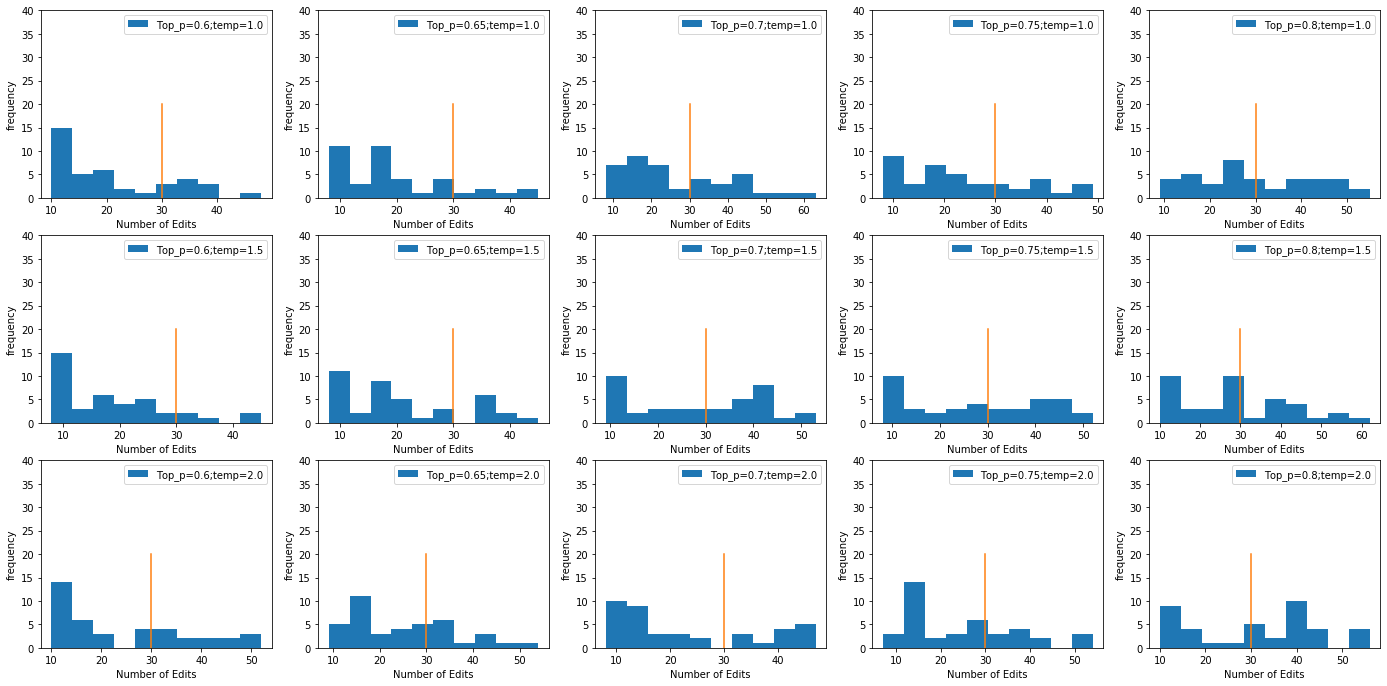

In [284]:
#Example of visualization once you have your data
plt.figure(figsize=(24,20))
for i in range(s_t):
    for j in range(s_c):
        plt.subplot(s_t,s_c,s_c*(k+1)+(j+1))
        plt.hist(np.round(M[i,j,]/2), bins = 10, label = "temp=" + str(round(T[i],2))+";"+"Top_p=" + str(round(C[j],2)))
        if j > -1: 
            plt.plot(30*np.ones(10),np.linspace(0,20,10)) 
        plt.ylim([0,40])
        #plt.xlim([10,130])
        plt.xlabel('Number of Edits')
        plt.ylabel('frequency')
        plt.legend()
plt.show()

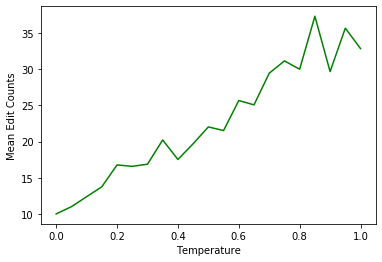

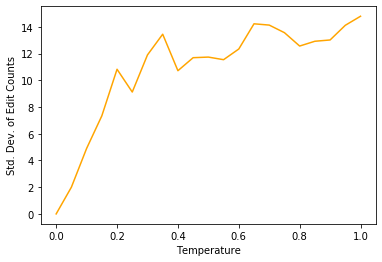

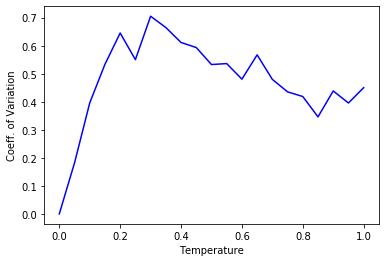

In [300]:
#Example Aggregate Visualizations

I_t = [0,1]
s_t = 2

#temprature transfer
F = M[:,0,:]
I = I_t
s = s_t

s,r = F.shape
T = np.linspace(I[0],I[1],21)
m = np.mean(F, axis = 0)
v = np.var(F, axis = 0)

plt.plot(T,m, c = 'g')
plt.ylabel('Mean Edit Counts')
plt.xlabel('Temperature')
plt.show()

plt.plot(T,np.sqrt(v), c = 'orange')
plt.ylabel('Std. Dev. of Edit Counts')
plt.xlabel('Temperature')
plt.show()

plt.plot(T,np.sqrt(v)/m, c = 'b')
plt.ylabel('Coeff. of Variation')
plt.xlabel('Temperature')
plt.show()

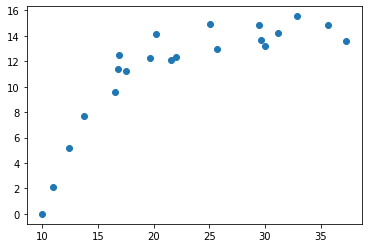

In [191]:
plt.scatter(m,np.sqrt(v)*(21)/20)
plt.show()